In [3]:
import sys
import numpy as np
import argparse
from math import *

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\code\\myPy')  
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\CUDA\\RSgpu\\Release')
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
import ablation_utils
import geom
import sonalleve
import transducers
import PBHE_CUDA

import importlib

import matplotlib.image as image
import matplotlib.pyplot as plt

plt.rc('font', family='sans-serif', size=24)
%matplotlib inline

def L2norm(arg):
    return np.sqrt(np.sum(np.abs(arg)**2))

In [20]:
importlib.reload(ablation_utils)

<module 'ablation_utils' from 'C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims\\ablation_utils.py'>

In [17]:
importlib.reload(transducers)

<module 'transducers' from 'C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy\\transducers.py'>

In [2]:
#parameters from Kohler
rho=1050
Cp=3500

c0=1540
f0=1.2e6
k0=f0*2*pi/c0
ktdiffusion=0.6


xw=4.0
yw=4.0
zmin=11.0
zmax=16.0

Nt=50
Nx=64
Ny=64
Nz=64

dataType = np.float32

simPhysGrid = ablation_utils.makeSimPhysGrid(nt=Nt,nx=Nx,ny=Nz,nz=Nz,rho=rho, ktherm=ktdiffusion, f0=f0,Cp=Cp,c0=c0,
    dt=0.1, xr=[-xw/2.0, xw/2.0], yr=[-yw/2.0, yw/2.0],zr=[zmin,zmax])

Rbase = np.zeros([Nx,Ny,Nz],dtype=dataType)
CEM0=np.zeros([Nx,Ny,Nz],dtype=dataType)
CEM1=np.zeros_like(CEM0)

[T,xrp,yrp,zrp]=[simPhysGrid[k] for k in tuple('T,xrp,yrp,zrp'.split(','))]
(dt,dx,dy,dz)=simPhysGrid['dtxyz']

gxp,gyp,gzp = np.meshgrid(xrp, yrp, zrp, sparse=False, indexing='ij')
calcGridDist= lambda rr: np.sqrt((gxp-rr[0])**2 + (gyp-rr[1])**2 + (gzp-rr[2])**2)

zplane=0.14
focplaneZpix=np.where(np.logical_and( (zrp[1:-1]-zplane>=0) , (zrp[0:-2]-zplane<0) ))[0][0]


yci=floor(Ny/2)
xci=floor(Nx/2)

In [86]:
simPhysGrid.keys()

dict_keys(['Tdotmesh', 'zrp', 'T', 'rhoCpmesh', 'xrp', 'Tmesh', 'rhoCp', 'dtxyz', 'kt', 'Tdot', 'rho', 'yrp', 'kmesh', 'c0', 'k0'])

In [9]:
RSkeys=dict(subsampN=10, ROC=0.14, subsampDiam=0.0066, gpublocks=512)


uxyz = sonalleve.get_sonalleve_xdc_vecs()
unvec = sonalleve.get_sonalleve_xdc_normals()

calibFocus = [0.0,0.0,0.14]
calibAmp = transducers.get_focused_element_vals(simPhysGrid['k0'],uxyz,[calibFocus], [1] )

ds=np.arange(-0.005,0.005,0.0005)
pp0=transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, calibAmp , calibFocus[0]+ds, [calibFocus[1]], calibFocus[2]+ds, **RSkeys)
Ip0 = np.abs(pp0)**2 / (2.0*rho*c0)

Ispta0 = 1e7

calibrationGain = (Ispta0/np.max(Ip0))

L2powRenorm = sqrt(calibrationGain)*L2norm(calibAmp)



In [152]:
Ifpks=[]
for r in [0.0,4,12,16]:
    rfocus = [r*1e-3, 0, 0.14]
    radialAmp = transducers.get_focused_element_vals(simPhysGrid['k0'],uxyz, [rfocus], [1], L2renorm=L2powRenorm )
    pr=transducers.calc_pressure_profile_cuda(simPhysGrid['k0'], uxyz, unvec,  radialAmp,[rfocus[0]], [rfocus[1]], [rfocus[2]], **RSkeys )
    Ifpks.append(np.abs(pr[0])**2/(2*rho*c0))
Ifpks=np.array(Ifpks)

In [155]:
Ifpks[0]/Ifpks[1:]

array([ 1.09275717,  2.37380273,  5.36283785])

#### Pre-computed intensities (update if maxR_mm changes)

In [37]:
#use the new routine options to get array settings for the trajectories from Kohler et al., 2009
maxR_mm = 12
(coords_mm, numTurns, numSonPerTurn) = ablation_utils.kohler_trajectories(maxR_mm, 140.0)

totSonications = np.sum(numSonPerTurn)

#single focus amplitudes
(times,trajAmps0)=ablation_utils.trajectorySettings([maxR_mm, 140.0], doRotation=False, use_kohler_traj=True, L2renorm=L2powRenorm, k0=k0, uxyz=uxyz )

I0precomputed = np.zeros([totSonications,Nx,Ny,Nz])

for soni in range(0,totSonications):
    print('\r%d / %d' %(soni+1,totSonications), end=' ',flush=True)
    P0 = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, trajAmps0[2*soni], xrp, yrp, zrp, **RSkeys )
    I0precomputed[soni][:] = np.abs(P0)**2 / (2*rho*c0)


48 / 48 

In [49]:
#multi-focus
pxyz,h = geom.ring(0.004,4,z=0)

(junk, trajAmps1)=ablation_utils.trajectorySettings([maxR_mm, 140.0], pxyz=pxyz, doRotation=False, use_kohler_traj=True, AlternatePhases=True, L2renorm=L2powRenorm, k0=k0, uxyz=uxyz )

try:
    del I1precomputed
except NameError:
    pass

I1precomputed = np.zeros([totSonications,Nx,Ny,Nz])

for soni in range(0,totSonications): 
    print('\r%d / %d' %(soni+1,totSonications), end=' ',flush=True)
    P1 = transducers.calc_pressure_field_cuda(simPhysGrid['k0'], uxyz, unvec, trajAmps1[2*soni], xrp, yrp, zrp, **RSkeys )
    I1precomputed[soni][:] = np.abs(P1)**2 / (2*rho*c0)

48 / 48 

In [112]:
np.max(I0precomputed,axis=(1,2,3))

array([ 7557729.77503304,  9111954.31626328,  7557729.77503304,
        9111954.31626325,  7557729.775033  ,  9111954.31626328,
        7557729.77503298,  9111954.31626331,  5900808.44900293,
        6520266.35492318,  5899342.81972755,  6520266.39178058,
        5900808.44900292,  6520266.35492311,  5899342.81972756,
        6520266.39178058,  5900808.44900303,  6520266.35492317,
        5899342.81972759,  6520266.39178057,  5900808.44900292,
        6520266.35492312,  5899342.81972756,  6520266.39178052,
        3419953.13526873,  3649850.70647752,  4121303.82778825,
        4068622.30896661,  4121303.46452917,  3649851.49833287,
        3419953.13526865,  3649850.70647749,  4121303.82778827,
        4068622.30896661,  4121303.46452919,  3649851.49833298,
        3419953.13526854,  3649850.70647738,  4121303.8277883 ,
        4068622.30896661,  4121303.4645292 ,  3649851.49833295,
        3419953.1352684 ,  3649850.70647728,  4121303.82778825,
        4068622.30896661,  4121303.46452

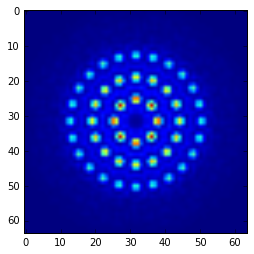

In [69]:
plt.imshow(np.sum(I0precomputed[:,:,:,focplaneZpix],axis=0),vmin=0.00001*Ispta0,vmax=Ispta0)

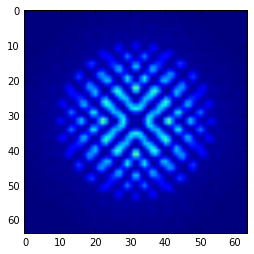

In [111]:
plt.imshow(np.sum(I1precomputed[:,:,:,focplaneZpix],axis=0),vmin=0.00001*Ispta0,vmax=Ispta0)

In [74]:
len(times)/2

48.5

In [76]:
times.shape

(97,)

### Heating

In [105]:
def timeEdgesVector(dwellSec, waitSec, Npass=1, storageVec=None, Npoints=0,tzero=0.0):
    """
    Return time edges, with each sonicaiton point including a dwell and a wait (possibly zero)
    """
    if storageVec is not None:
        Npoints = floor(len(storageVec)/2)*Npass
    else:
        storageVec = np.zeros(2*Npoints*Npass + 1)
        
    if Npoints <=0:
        return None

    storageVec[0]=tzero
    for ti in range(0,Npoints*Npass):
        storageVec[2*ti+1] = storageVec[2*ti] + dwellSec
        storageVec[2*ti+2] = storageVec[2*ti+1] + waitSec
        
    return storageVec

def heating(timeEdges, intensitySet, CEM, CEMinit=0,T0=37.0, alpha=1.0, PBdict={} ):

    T[0] = T0
    CEM[:]=CEMinit
    
    [Tdot, Tmesh, Tdotmesh, kmesh, rhoCpmesh, rhoCp]=[simPhysGrid[k] for k in tuple('Tdot,Tmesh,Tdotmesh,kmesh,rhoCpmesh,rhoCp'.split(','))]
    
    numSons = intensitySet.shape[0]

    for soni in range(0,numSons):
        print('\r%d / %d' %(soni+1,numSons), end=' ')
        duration = timeEdges[2*soni + 1] - timeEdges[2*soni]
        Tdot[:] = dataType(2.0*alpha*intensitySet[soni] / rhoCp)
        ablation_utils.calc_heating(simPhysGrid, T, Tdot, Tmesh, Tdotmesh, kmesh, rhoCpmesh, duration, CEM, Rbase, GPU=False, interpoffset=timeEdges[2*soni], **PBdict)

        Tdot[:] = 0
        duration = timeEdges[2*soni + 2] - timeEdges[2*soni+1]
        ablation_utils.calc_heating(simPhysGrid, T, Tdot, Tmesh, Tdotmesh, kmesh, rhoCpmesh, duration, CEM, Rbase, GPU=False, interpoffset=timeEdges[2*soni + 1], **PBdict)

    return duration

In [108]:
timeEdgesVector(1.0, 0.0, Npoints=totSonications);

heating(times, I1precomputed, CEM0, T0=T[0], alpha=2.0, PBdict=dict(verbose=False,Freeflow=1))

48 / 48 

0.0

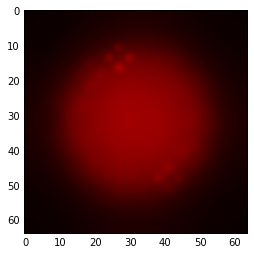

In [114]:
plt.imshow(T[0][:,:,focplaneZpix],vmin=37,vmax=50,cmap=image.cm.hot)

In [103]:
heating(times, I0precomputed, CEM0, alpha=2.0, PBdict=dict(verbose=False,Freeflow=1))

48 / 48 

0.0

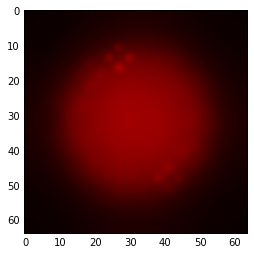

In [113]:
plt.imshow(T[0][:,:,focplaneZpix],vmin=37,vmax=50,cmap=image.cm.hot)